<a href="https://colab.research.google.com/github/bradshawjoshua/Early-Detection-Stroke/blob/main/Early_Detection_of_Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


#Index


##1.   Introduction 
##2.   Data Wrangling
##3.   Data Exploratory Analysis
##4.   Modeling
##5.   Conclusion
##6.   Considerations


#Introduction

In [89]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from sklearn.tree import plot_tree
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
import missingno
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn import metrics
set_config(display='diagram')

In [2]:
#published the patient data
patient_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRLxbgMrEStijFqkwjzGG8yCo5BbaZGuKnFQ04-HnJpJQT421ckhYp6RGYVOCToEPVIjcC2BUX5QM4z/pub?gid=282721792&single=true&output=csv'
df = pd.read_csv(patient_data)
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
#exploring dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


>BMI and smoking_status both have missing values. Since smoking_status has already been handled prior to publish. I will handle BMI by dropping the values for EDA.

#Data Wrangling

In [4]:
#dropping the nominal feature 'id' for our EDA and ML process
df.drop(columns=['id'], inplace = True)

In [5]:
#checking for duplicates
df.duplicated().sum()

0

In [6]:
#scanning for outliers
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
#checking for missings using sum function
df.isna().sum()

In [7]:
df_ml = df.copy()

>Using this copy later for my machine learning models section

In [8]:
#handling missing BMI values by dropping
df.dropna(inplace=True)

In [9]:
#verifying it was dropped
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

>The CSV file actually displays missing 'bmi' values as 'N/A' (i.e., 'Not Applicable'), but this does not make sense. Unless, the client chose not to get their BMI. Also, there are various ways to test BMI, so there are a lot of factors, and SMEs would need to be inquired on the methods used to obtain BMI from all patients. Everyone should have a BMI, regardless of age or gender. Dropping the 'bmi' values, instead of imputing the 'N/A' (3.9%) for the EDA process. I can assume the mean or median, but I'd rather base my data on actual BMI scores for my client. I will test imputation later to see if my findings vary, but I suspect only a slight change. 

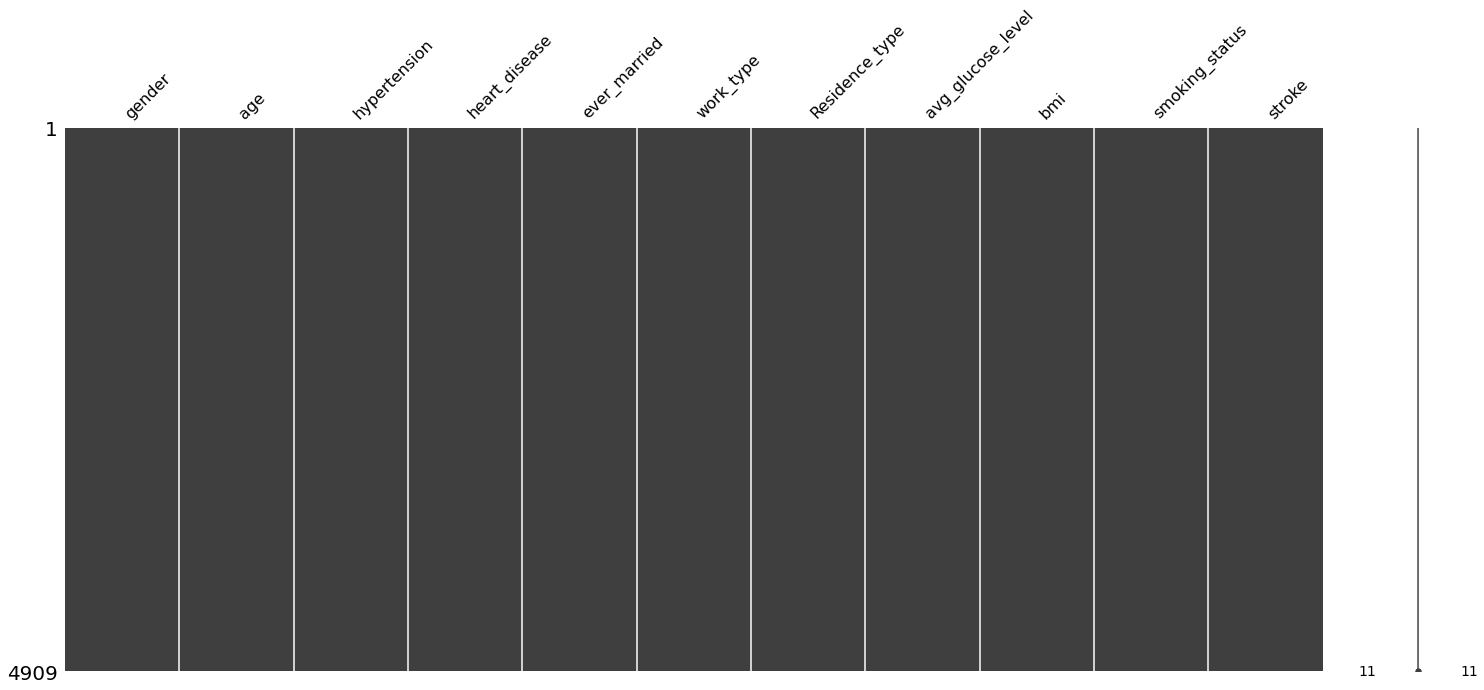

In [10]:
#visual check for missing values
missingno.matrix(df)

In [11]:
#preparing to check for inconsistent string values
data_types = df.dtypes
str_cols = data_types[data_types=='object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [12]:
#using a for loop to check for inconsistent object values (spelling errors) 
for col in str_cols:
  print(f'{col}:')
  print(df[col].value_counts(dropna=False))
  print('\n\n')

gender:
Female    2897
Male      2011
Other        1
Name: gender, dtype: int64



ever_married:
Yes    3204
No     1705
Name: ever_married, dtype: int64



work_type:
Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64



Residence_type:
Urban    2490
Rural    2419
Name: Residence_type, dtype: int64



smoking_status:
never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64





>All object values are acceptable, except 'Other' in the gender column. Since there is only one record and it isn't specific enough, we will drop this record from our EDA.

In [13]:
#handling the outlier 'gender' value of 'Other' by indexing it
df.loc[df['gender']=='Other',:]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [14]:
#dropping the record
df.drop(index = 3116, inplace = True)

#Data Exploratory Analysis

##Univariate Analysis

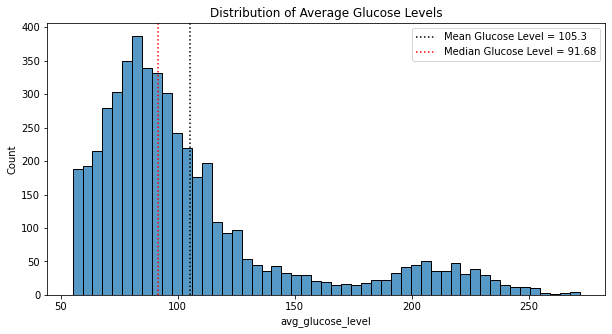

In [15]:
#univariate histogram for avg_glucose_level
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df, x='avg_glucose_level', ax=ax)
ax.set(title='Distribution of Average Glucose Levels');

#annotating mean and median for avg_glucose_level
mean_glucose_level = df['avg_glucose_level'].mean()
ax.axvline(mean_glucose_level, color='black', ls=':', 
           label=f'Mean Glucose Level = {round(mean_glucose_level, 2)}');

med_glucose_level = df['avg_glucose_level'].median()
ax.axvline(med_glucose_level, color='red', ls=':',
           label=f'Median Glucose Level = {round(med_glucose_level, 2)}');

ax.legend();

>We have some outliers showing hyperglycemia for 180+ for glucose level. Diabetes for 200+.

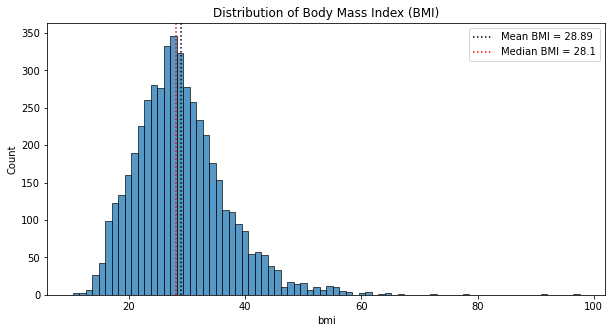

In [16]:
#univariate histogram for bmi
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df, x='bmi', ax=ax)
ax.set(title='Distribution of Body Mass Index (BMI)');

#annotating mean and median for bmi
mean_bmi = df['bmi'].mean()
ax.axvline(mean_bmi, color='black', ls=':', 
           label=f'Mean BMI = {round(mean_bmi, 2)}');

med_bmi = df['bmi'].median()
ax.axvline(med_bmi, color='red', ls=':',
           label=f'Median BMI = {round(med_bmi, 2)}');

ax.legend();

>Our patients BMI show a distribution (bell shaped) that display a mean and median of around 28. That means our average patient is overweight, with some acceptable outliers.  

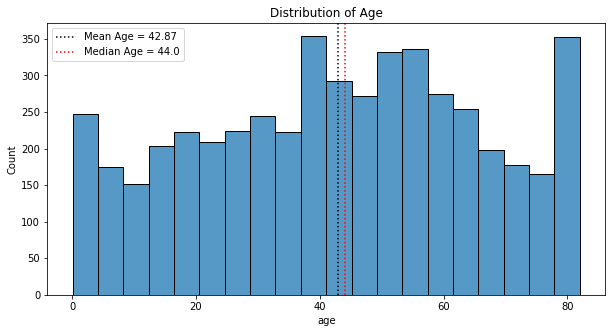

In [17]:
#univariate histogram for age
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df, x='age', ax=ax)
ax.set(title='Distribution of Age');

#annotating mean and median for age
mean_age = df['age'].mean()
ax.axvline(mean_age, color='black', ls=':', 
           label=f'Mean Age = {round(mean_age, 2)}');

med_age = df['age'].median()
ax.axvline(med_age, color='red', ls=':',
           label=f'Median Age = {round(med_age, 2)}');

ax.legend();

>Age seems to distribute more toward a middle aged cohort.

##Multivariate Anaylsis

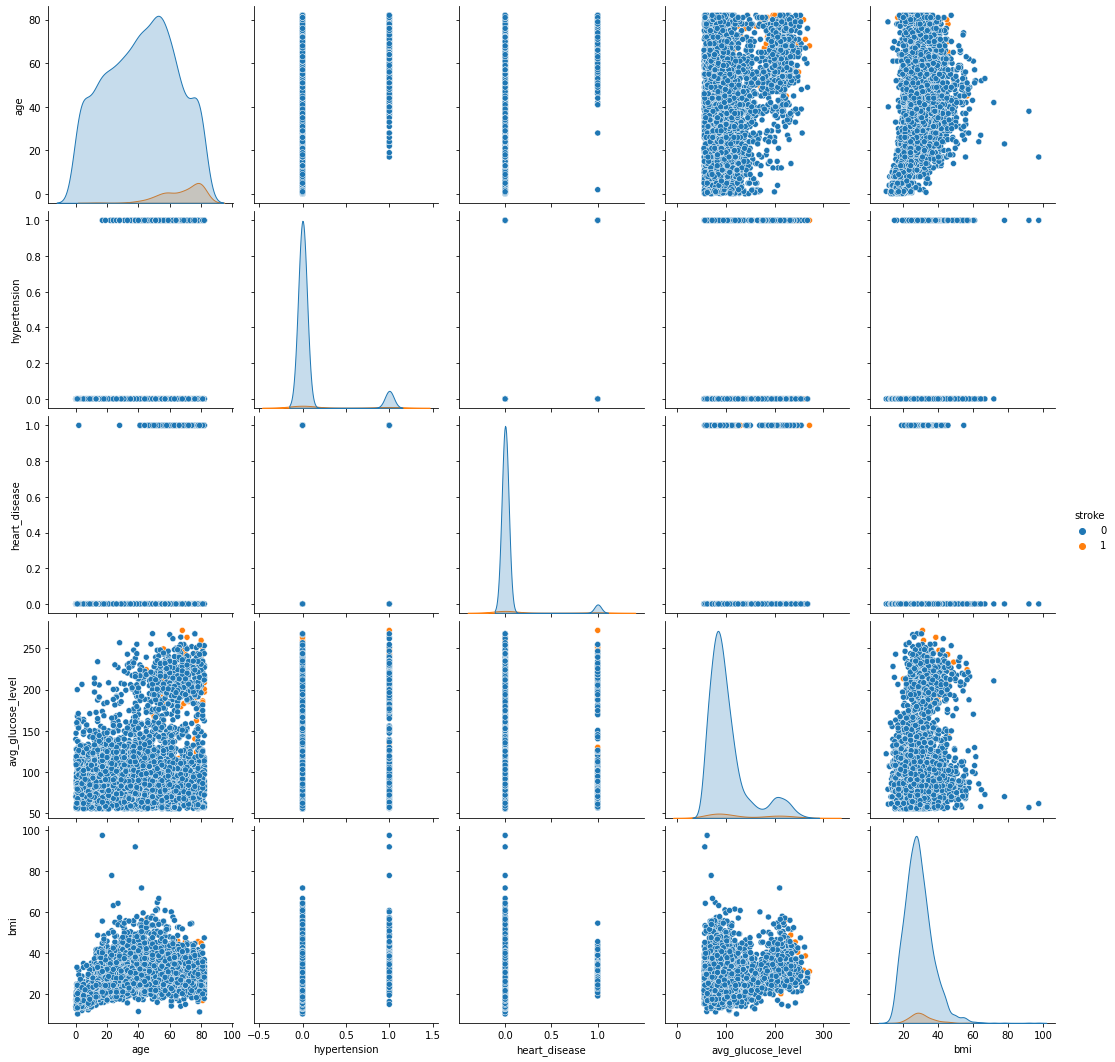

In [18]:
#scanning for insights in relation to stroke; 0 no stroke, 1 stroke
sns.pairplot(data = df, hue="stroke", height=3)

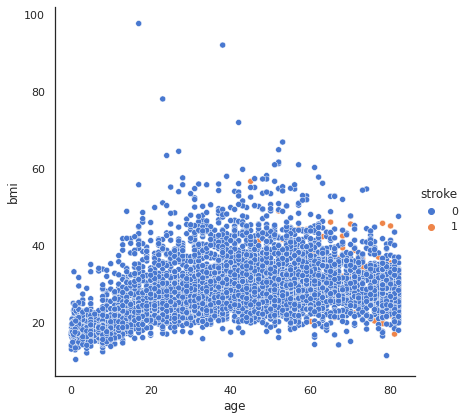

In [19]:
#drilling deeper by checking stroke (target) to view its relationship between bmi and age
sns.set_theme(style="white")

#0 does not have stroke, and 1 for had stroke
sns.relplot(x="age", y="bmi", hue="stroke",
            sizes=(80, 400), alpha=1, palette="muted",
            height=6, data=df)

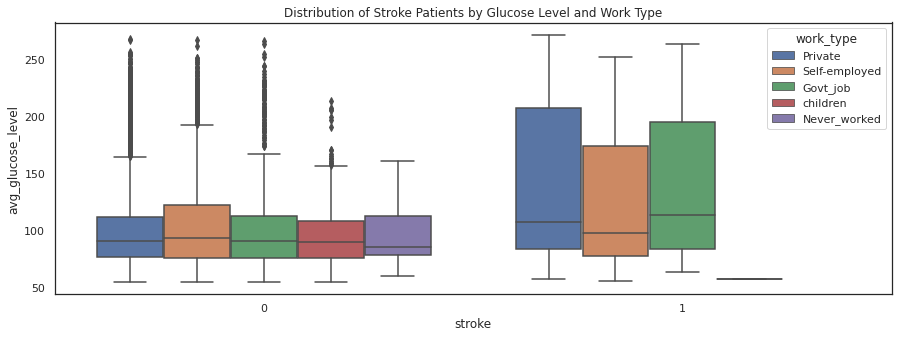

In [20]:
#checking for outliers among work_type with stroke categories
fig, ax = plt.subplots(figsize=(15,5))

ax.set(title='Distribution of Stroke Patients by Glucose Level and Work Type');
sns.boxplot(x = "stroke", y = "avg_glucose_level", 
            data = df, hue = "work_type")

This shows there are some patients who have high glucose levels but do not have stroke (extreme outliers) while patients with stroke show much higher distribution for high glucose levels (>150).

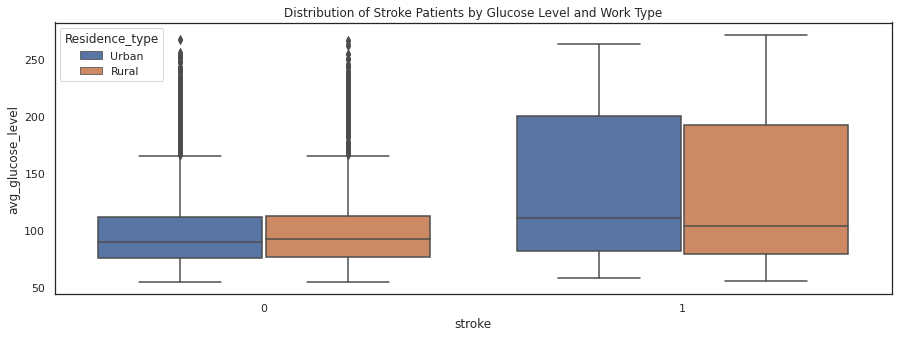

In [21]:
#checking for outliers among work_type with stroke categories
fig, ax = plt.subplots(figsize=(15,5))

ax.set(title='Distribution of Stroke Patients by Glucose Level and Work Type');
sns.boxplot(x = "stroke", y = "avg_glucose_level", 
            data = df, hue = "Residence_type")

>Residence type does not provide a distinction to stroke by glucose level.

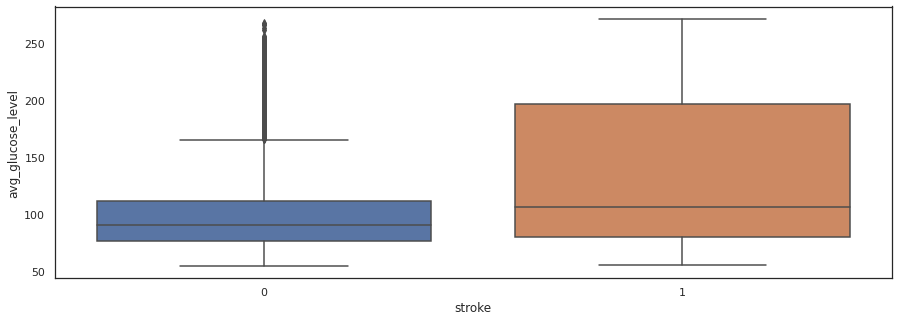

In [22]:
#checking for outliers among work_type with stroke categories
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x = "stroke", y = "avg_glucose_level", 
            data = df)

>Patients with higher glucose levels contribute more to having a stroke (1).

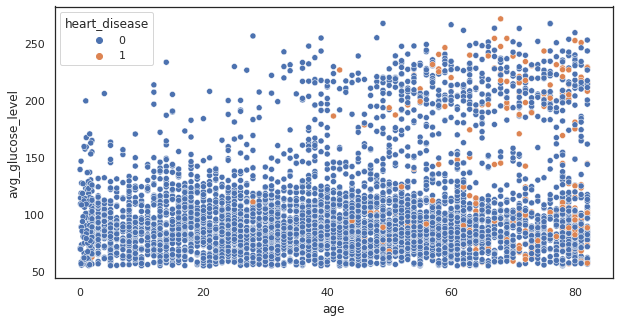

In [23]:
#checking heart disease trends among age and glucose levels
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot( x = "age", 
                 y = "avg_glucose_level", 
                 data = df, 
                 hue = "heart_disease")

>Ages 65+ show a relationship to having heart disease. Our sample is underrepresented, but we can see patients with heart disease trend toward older age groups.



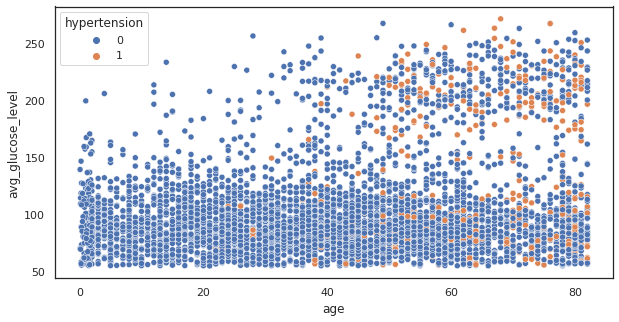

In [24]:
#checking hypertension trends among age and glucose levels
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot( x = "age", 
                 y = "avg_glucose_level", 
                 data = df, 
                 hue = "hypertension")

>Hypertension (1) is densely populated in the upper right quadrant of this scatter plot, displaying patients with high glucose levels from ages 40 to 80.

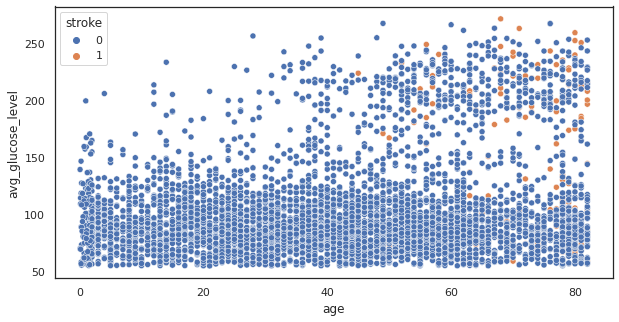

In [25]:
#looking at glucose levels in relationship to age and stroke
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot( x = "age", 
                 y = "avg_glucose_level", 
                 data = df, 
                 hue = "stroke")

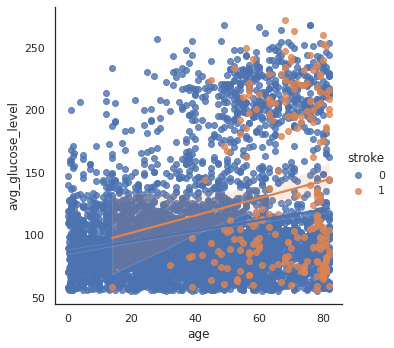

In [26]:
#continuing to explore glucose levels in relationship to age and stroke
sns.lmplot(data=df, x = 'age', y ='avg_glucose_level', hue='stroke')

>Stroke shows a distinct representation of age by glucose level. We can see that stroke seems to happen to around ages 45-80 more than the rest of the age values. Patients most impacted to stroke are those with high glucose levels and are 65+ in age.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 42.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, '')]

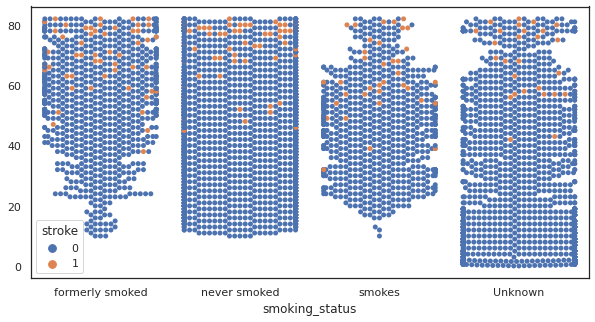

In [27]:
#exploring the smoking status feature and its potential relation to age and stroke
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='smoking_status', y='age', data=df, 
              hue='stroke')
ax.set(ylabel="")

>No clear distinction of stroke in relation to smoking person type and age. Regardless of smoking type, it is clear that cohorts 40-80 years of age are impacted most by stroke. 

##Extra Information (for later use)

##Average Glucose Level Chart (Mean Blood mg/dL)

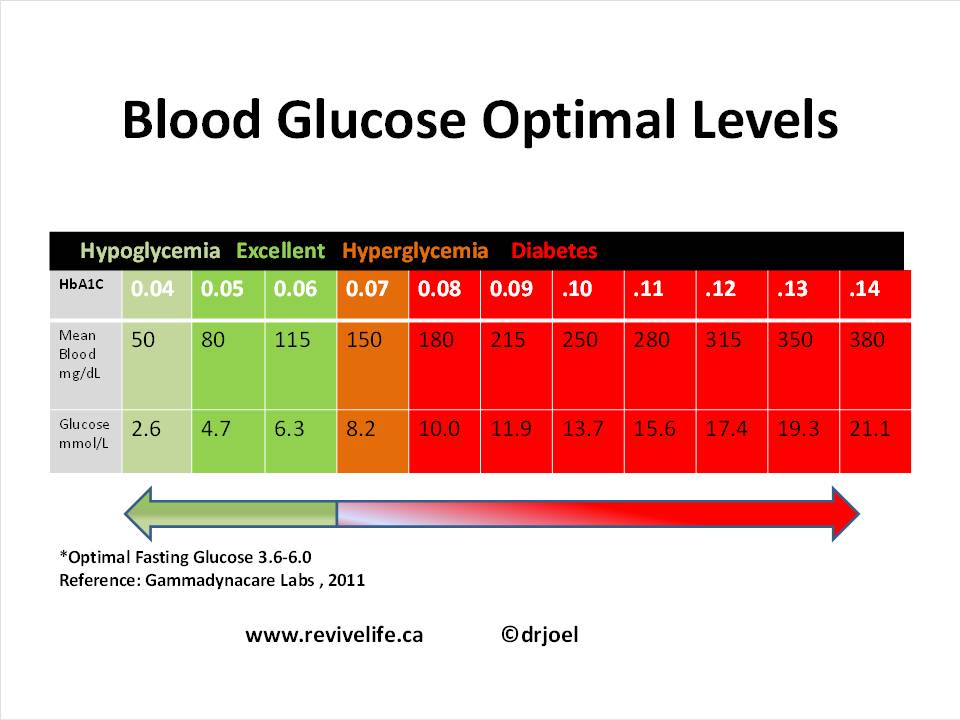

Source: https://www.health.gov.fj/diabetes-2/diabetes/

##BMI Visual Chart

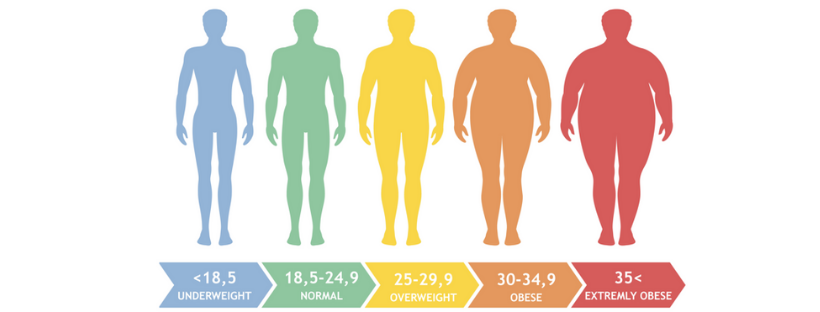

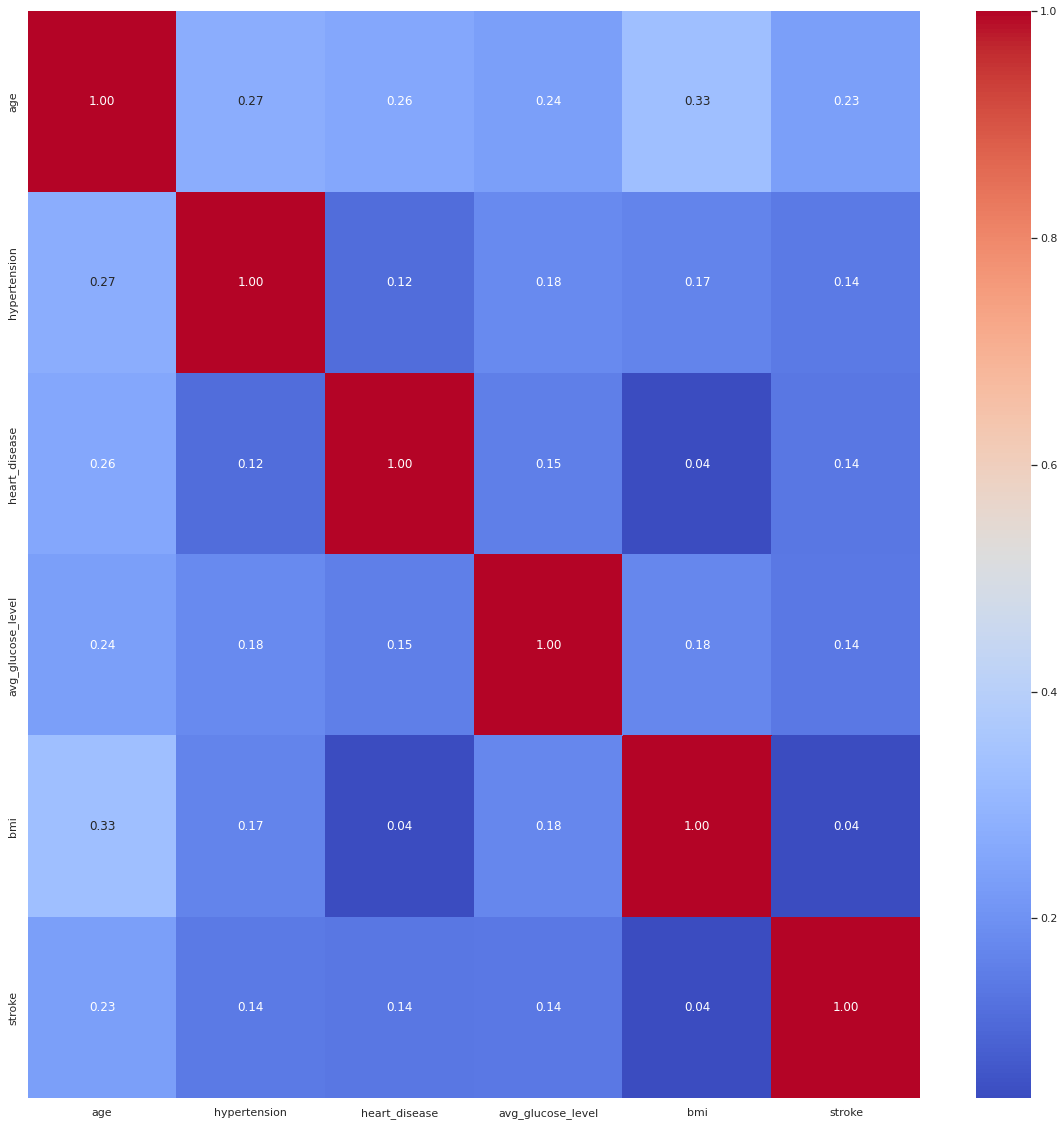

In [28]:
#running a heat map on numeric features
corr = df.corr()
corr

plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt ='.2f')

>Stroke's highest correlation is in relation to a person's age. Unfortunately, all features are below 0.5, which isn't ideal, but we will use this to start creating informative charts.

##Visualizations Continued

We will define our own age categoies
*    Children (00-16 years)
*    Young Adults (17-30 years)
*    Middle-aged Adults (31-45 years)
*    Old-aged Adults (45 years and over)

In [29]:
#scanning distribution of age, glucose level, and bmi
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,42.868810,0.091891,0.049511,105.297402,28.89456,0.042584
std,22.556128,0.288901,0.216954,44.425550,7.85432,0.201937
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.10000,0.000000
75%,60.000000,0.000000,0.000000,113.495000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


>Our oldest patient is 82. We also have patienrts with extremely levels of glucose levels and BMI, which indicates diabetic and obese patients.

In [30]:
#creating a copy of the df to cut and bin my categories into four buckets
df2 = pd.DataFrame.copy(df)
bins=[0,16,30,45,120]
labels=['Children','Young Adults','Middle Adults','Older Adults']
df2['Age Categories']=pd.cut(df['age'],bins=bins,labels=labels)

<Figure size 1080x720 with 0 Axes>

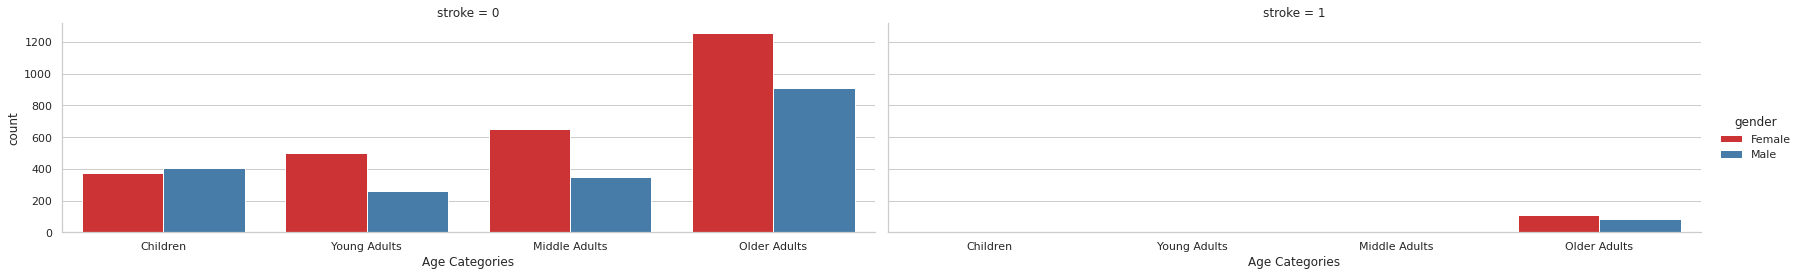

In [31]:
#using a catplot to show stroke patient in age and gender groups
plt.figure(figsize=[15,10])
sns.set_theme(style="whitegrid")
sns.catplot(data=df2.sort_values('Age Categories'),x='Age Categories', col="stroke", hue="gender", palette="Set1", height=4, aspect=3, kind="count");

>This shows that there are more observations of female in our data set, but we can clearly see with this chart that Older Adults (>45) are affected most by stroke.

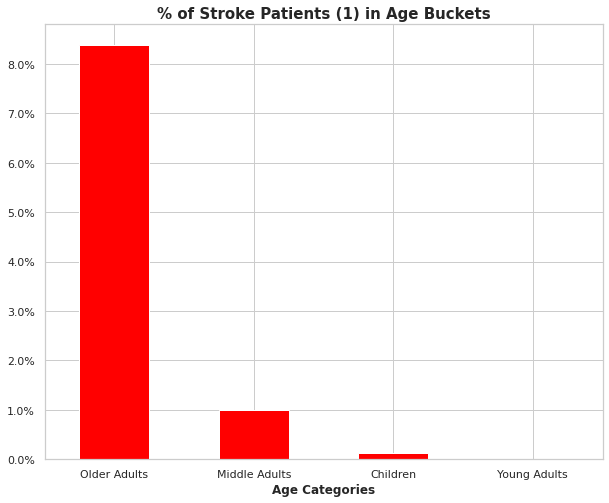

In [32]:
#now we will show a distribution (%) of patient buckets with stroke only, using df2
plt.figure(figsize=[10,8])

(100*df2[df2["stroke"].isin([1])]['Age Categories'].value_counts()/df2['Age Categories'].value_counts()).plot(kind='bar', stacked=True, color='red')
plt.title("% of Stroke Patients (1) in Age Buckets" , fontsize = 15, fontweight ='bold'  )

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Age Categories' , fontweight ='bold')
plt.xticks(rotation=0)
plt.show()

>The chart above this one doesn't show the extreme outliers. This chart tells a slightly different story. It tells us that a very small percentage from Middle Adults and Children aged buckets are also affected by stroke, just not as much as Older Adults.

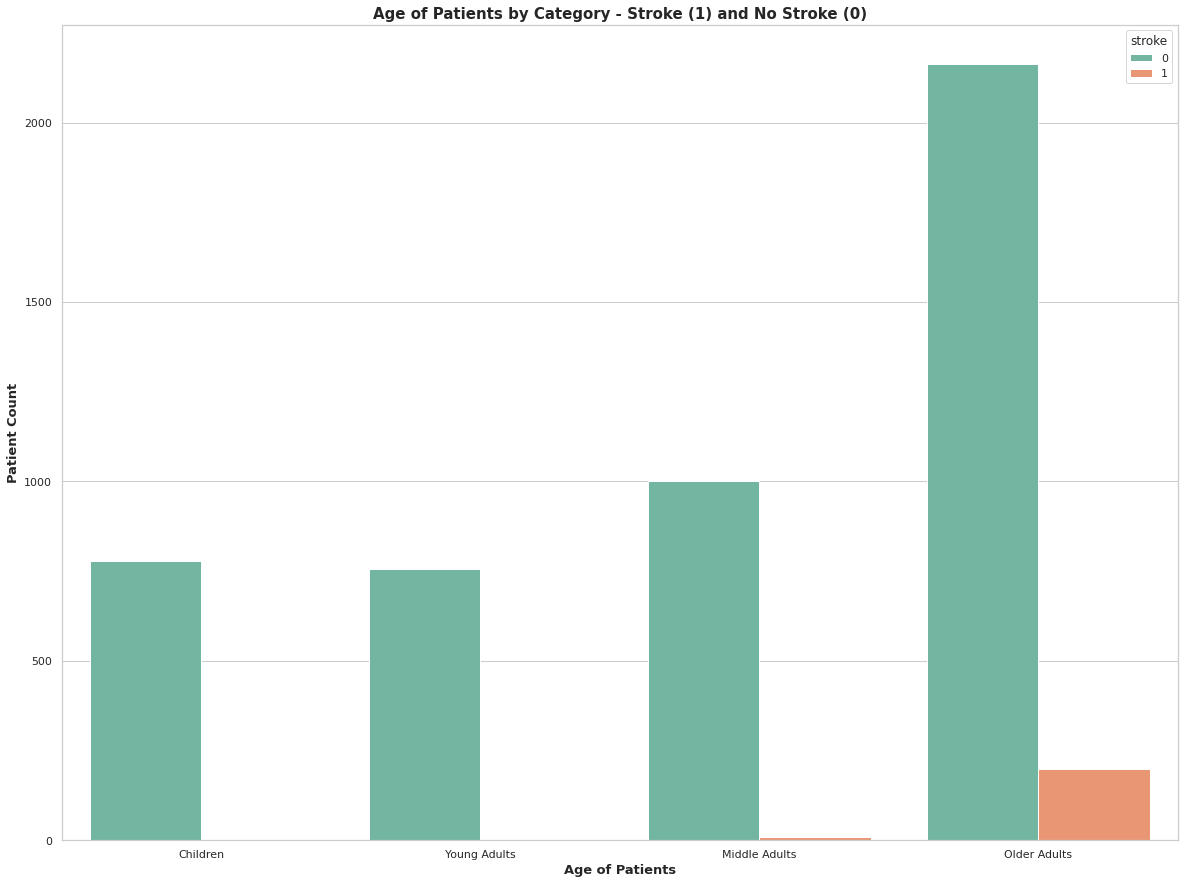

In [33]:
#creating a countplot to display stroke patients who are primarily affected
plt.figure(figsize=[20,15])
sns.countplot(data=df2.sort_values('Age Categories'),x='Age Categories', hue='stroke', palette='Set2');

plt.title('Age of Patients by Category - Stroke (1) and No Stroke (0)' , fontsize = 15, fontweight ='bold');
plt.xlabel('Age of Patients', fontsize = 13, fontweight ='bold')
plt.ylabel('Patient Count', fontsize = 13, fontweight ='bold')
plt.show()

>Instead of a percentage we can capture the count. Just under 250 patients in the Older Adults bucket is affect by stroke and a very small count of Middle Adults are affected. We could suggest our client who would need to get more frequent check-ups.

In [34]:
#initializing disease variable to group hyptension and hd
disease_type = df.groupby(['hypertension', 'heart_disease'])
disease_type['stroke'].count()

hypertension  heart_disease
0             0                4272
              1                 185
1             0                 393
              1                  58
Name: stroke, dtype: int64

In [35]:
#creating a disease type v1 to view only the disease type with stroke, using isin 
disease_type_1=df[df["stroke"].isin([1])].groupby(["hypertension", "heart_disease"])
disease_type_1['stroke'].count()

hypertension  heart_disease
0             0                120
              1                 29
1             0                 49
              1                 11
Name: stroke, dtype: int64

In [36]:
#creating a percentage of hypertension and hd patients who have stroke only
100*disease_type_1['stroke'].size()/disease_type['stroke'].size()

hypertension  heart_disease
0             0                 2.808989
              1                15.675676
1             0                12.468193
              1                18.965517
Name: stroke, dtype: float64

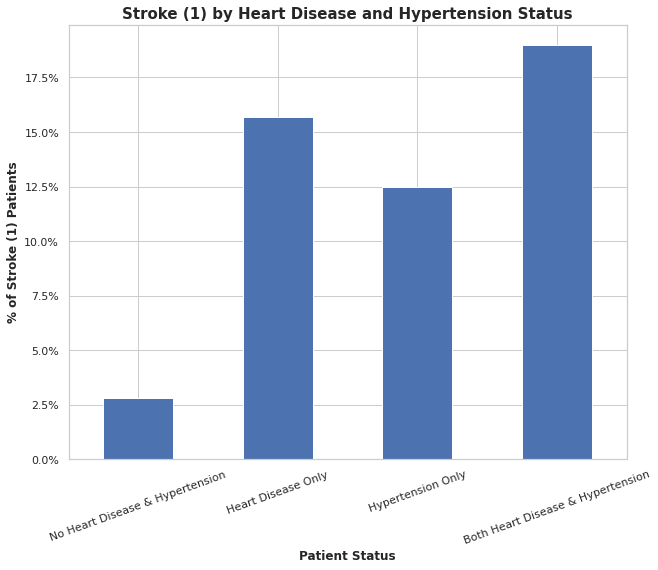

In [37]:
#displaying the output above
plt.figure(figsize=[10,8])
x_labels=["No Heart Disease & Hypertension","Heart Disease Only", "Hypertension Only","Both Heart Disease & Hypertension"]
(100*disease_type_1['stroke'].size()/disease_type['stroke'].size()).plot(kind='bar', stacked=True).set_xticklabels(x_labels)
plt.title("Stroke (1) by Heart Disease and Hypertension Status" , fontsize = 15, fontweight ='bold')


plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Patient Status' , fontweight ='bold')
plt.ylabel('% of Stroke (1) Patients' , fontweight ='bold')
plt.xticks(rotation=20)
plt.show()

>This chart provides insight on which groups our client needs to focus on most. It appears that every patient status (even patients with no problems) are affected by stroke. I would suggest to our client that patients with heart disease and hypertension are at most risk of incurring a stroke, with both being the worst possible case.

#Modeling

In [38]:
# scanning for ordinal values
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


>Establishing Order: 0 - Unknown; 1 - never smoked; 2 - formerly smoked; 3 - smokes

In [39]:
# split X and y, predicting Drug Type (drugZ or drugQ)
X = df_ml.drop(columns=['stroke'])
y = df_ml['stroke']

# setting random_state to 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Preprocessing

In [40]:
#handling missing values for future data pulls
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')

In [41]:
# telling the column transformers which columns to apply which preprocessing to
number_pipe = make_pipeline(mean_imputer, scaler)
num_selector = make_column_selector(dtype_include='number')
number_tuple = (number_pipe, num_selector)

category_selector = make_column_selector(dtype_include='object')
cat_tuple = (ohe, category_selector)

In [42]:
#creating my column transfomer nesting the tuples to and using remainder drop
column_transformer = make_column_transformer(number_tuple, cat_tuple, remainder='drop')

In [44]:
#fitting on train only
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)])

In [45]:
#transform train and test
X_train_processed = column_transformer.transform(X_train)
X_test_processed = column_transformer.transform(X_test)

In [47]:
#checking for missing values, data is scaled, ordinal encoded, and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (3832, 20)




array([[ 0.7372167 ,  3.1393509 , -0.24139427, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10654894, -0.31853719, -0.24139427, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.38194696, -0.31853719, -0.24139427, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.87579225, -0.31853719, -0.24139427, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.62539105, -0.31853719, -0.24139427, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.11549465, -0.31853719, -0.24139427, ...,  0.        ,
         0.        ,  1.        ]])

###Function for Classification Reporting

In [48]:
# Defining a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
    
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.show()

##Logistic Regression Baseline

In [49]:
#trying a default Logistic Regression model in the pipeline
logreg = LogisticRegression()

#making the pipeline with the column_transformer
logreg_pipe = make_pipeline(column_transformer, logreg)

In [50]:
#fitting on training data only
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)])),
                ('logisticregression', LogisticRegression())])

In [51]:
#printing the accuract of the training and test score
print('Logisitic Regression Baseline Training Score')
print(logreg_pipe.score(X_train, y_train))
print('\nLogisitic Regression Baseline Test Score Baseline')
print(logreg_pipe.score(X_test, y_test))

Logisitic Regression Baseline Training Score
0.9558977035490606

Logisitic Regression Baseline Test Score Baseline
0.9381846635367762


>Our model has learned too much from training data. Based on this data set, we see a bit of variance (overfit). We can either get more data or regularize our data set to improve the performance of our accuracy.

##Logistic Regression L1

{0.0001: 0.9374021909233177,
 0.001: 0.9374021909233177,
 0.01: 0.9374021909233177,
 0.1: 0.9374021909233177,
 1: 0.9381846635367762,
 10: 0.9381846635367762,
 100: 0.9381846635367762,
 1000: 0.9381846635367762}

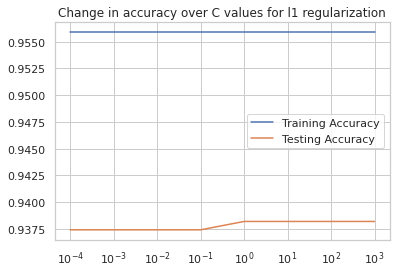

In [54]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg_1 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(column_transformer, log_reg_1)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

In [102]:
#printing the accuracy of the training and test score
print('L1 Tuned Logistic Regression Training Accuracy')
print(log_reg_pipe.score(X_train, y_train))
print('\nL1 Tuned Logistic Test Accuracy')
print(log_reg_pipe.score(X_test, y_test))

L1 Tuned Logistic Regression Training Accuracy
0.9558977035490606

L1 Tuned Logistic Test Accuracy
0.9381846635367762


In [56]:
#preparing variables to evaluate our accuracy for identifying the correct drug type
train_preds_l1 = log_reg_pipe.predict(X_train)
test_preds_l1 = log_reg_pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



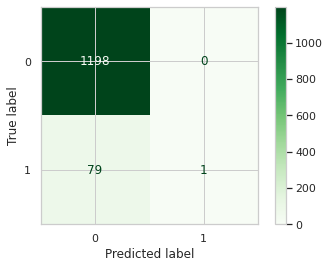

In [57]:
# classification report
evaluate_classification(log_reg_pipe, X_test, y_test)

>Noticing underrepresented data for stroke (1). Also, False Negative, meaning our model predicted negative for stroke (1), but its actually positive. This is not good, we will need to find a way to push the decision threshold more toward false positives. Allowing a false check-up with the doctor may cost more, but it's safer.

##Logistic Regression Balanced

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1198
           1       0.17      0.74      0.27        80

    accuracy                           0.75      1278
   macro avg       0.57      0.75      0.56      1278
weighted avg       0.93      0.75      0.82      1278



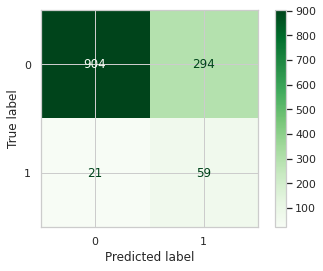

In [58]:
# attempting to balance the class weight for lg
 
logreg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)

logreg_balanced_pipe = make_pipeline(column_transformer, logreg_balanced)

logreg_balanced_pipe.fit(X_train, y_train)

evaluate_classification(logreg_balanced_pipe, X_test, y_test)

In [101]:
#printing the accuracy of the training and test score
print('Logistic Regression Balanced Training Accuracy')
print(logreg_balanced_pipe.fit(X_train, y_train)
.score(X_train, y_train))
print('\nLogistic Regression Test Accuracy')
print(logreg_balanced_pipe.fit(X_train, y_train)
.score(X_test, y_test))

Logistic Regression Balanced Training Accuracy
0.7502609603340292

Logistic Regression Test Accuracy
0.7535211267605634


>Although we lose a lot of accuracy, this model shows less False Positives and makes more balanced errors on False Negatives (something we'd like to avoid). We do not want patients to miss a chance at early detection of stroke due to our model's prediction.

##Logistic Regression SMOTE

In [59]:
# Import SMOTE
from imblearn.over_sampling import SMOTE
# Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe

In [60]:
#print y_train value counts before over sampling
y_train.value_counts()

0    3663
1     169
Name: stroke, dtype: int64

In [61]:
# Instantiate SMOTE 
smote = SMOTE(sampling_strategy='auto')
# Oversample X_train and y_train
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
# print new value counts
y_train_smote.value_counts()

0    3663
1    3663
Name: stroke, dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      1198
           1       0.16      0.71      0.27        80

    accuracy                           0.76      1278
   macro avg       0.57      0.74      0.56      1278
weighted avg       0.92      0.76      0.82      1278



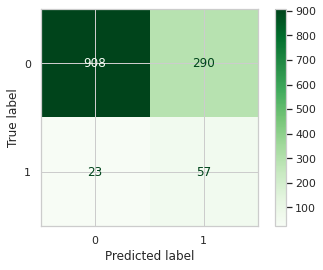

In [62]:
# creating a new LogisticRegression
logreg_smote = LogisticRegression(max_iter=1000)

# using the smote pipeline to combine preprocessor, smote, and model
log_reg_smote_pipe = smote_pipe(column_transformer, smote, logreg_smote)
# fitting the model
log_reg_smote_pipe.fit(X_train, y_train)

evaluate_classification(log_reg_smote_pipe, X_test, y_test)

In [100]:
#printing the accuracy of the training and test score
print('Logistic Regression SMOTE Training Accuracy')
print(logreg_balanced_pipe.fit(X_train, y_train)
.score(X_train, y_train))
print('\nLogistic Regression SMOTE Test Accuracy')
print(logreg_balanced_pipe.fit(X_train, y_train)
.score(X_test, y_test))

Logistic Regression SMOTE Training Accuracy
0.7502609603340292

Logistic Regression SMOTE Test Accuracy
0.7535211267605634


>Unfortunately, our accuracy did not improve with the use of SMOTE. We may need to ask the client to see if more data is available for patients with stroke (1). This is a difficult challenge since the majority of our data shows patients who do not have stroke. Just like our balancing method, SMOTE did capture more False Positives, which is favorable for our goal. We want our model to predict more False Positives to enable tests that could potentially save a patients life.

In [63]:
print(f'Training AUC: {roc_auc_score(y_train, log_reg_pipe.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, log_reg_pipe.predict_proba(X_test)[:,1])}')

Training AUC: 0.849799772876696
Testing AUC: 0.8417779632721202


##Logistic Regression and AUC - ROC Curve

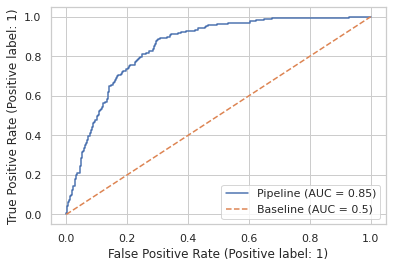

In [64]:
# Visualizing the ROC curve
RocCurveDisplay.from_estimator(log_reg_pipe, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

> When AUC is 0.5, it means the model has no class separation capacity. Again, the goal is to train our model to capture more False Positives instead of False Negatives, which will require more patients who don't have stroke to get an early check-up, but this is better than stroke going unnoticed. The AUC is 0.85, which means there is a 85% chance that this model will be able to distinguish between positive and negative classes.

##KNN Baseline

In [65]:
#trying a default KNN model in the pipeline
#instantiating the KNN model
knn = KNeighborsClassifier()

#making the pipeline with the column_transformer
knn_pipe = make_pipeline(column_transformer, knn)

In [66]:
# Looking at some hyperparameters that seem tunable
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [67]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [68]:
#instantiating pred variables for knn preds X_train and X_test
train_preds = knn_pipe.predict(X_train)
test_preds = knn_pipe.predict(X_test)

In [69]:
# Evaluating the accuracy of the train and test sets
print('Accuracy of Train set', accuracy_score(y_train, train_preds))
print('Accuracy of Test set', accuracy_score(y_test, test_preds))

Accuracy of Train set 0.9566805845511482
Accuracy of Test set 0.935054773082942


##KNN Best Neighbor

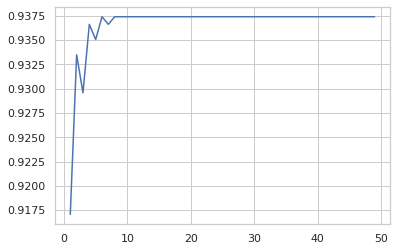

Best K value is 6 
with 0.9374021909233177 accuracy on the test set


In [70]:
#deploying a for loop to find the best accuracy
krange = range(1, 50)
test_accuracies = []
bestacc = 0
bestk = 0
for k in krange:
  #find accuracy for each k
  pipe = make_pipeline(column_transformer, KNeighborsClassifier(n_neighbors=k))
  pipe.fit(X_train, y_train)
  acc = accuracy_score(y_test, pipe.predict(X_test))
  #if accuracy for this k is better than previous accuracies, set bestk = k
  if acc > bestacc:
    bestacc = acc
    bestk = k

  test_accuracies.append(acc)

#plot accuracies over K
plt.plot(krange, test_accuracies, label='Test K Scores')
plt.show()

#print best k and best accuracy
print(f'Best K value is {bestk} \nwith {bestacc} accuracy on the test set')

>We will use the best K value of 6 by instantiating a new model and rerunning our pipeline

In [71]:
#setting our best_knn model for n_neighbors to a value of 6
best_knn = KNeighborsClassifier(n_neighbors=6)

In [72]:
#making the pipeline and fitting it on the train data
knn_pipe_2 = make_pipeline(column_transformer, best_knn)
knn_pipe_2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=6))])

In [73]:
#preparing variables to evaluate or accuracy for identifying the correct drug type
train_preds_2 = knn_pipe_2.predict(X_train)
test_preds_2 = knn_pipe_2.predict(X_test)

In [74]:
#evaluating the best model's accuracy
print('Accuracy of Train set', accuracy_score(y_train, train_preds_2))
print('Accuracy of Test set', accuracy_score(y_test, test_preds_2))

Accuracy of Train set 0.956419624217119
Accuracy of Test set 0.9374021909233177


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


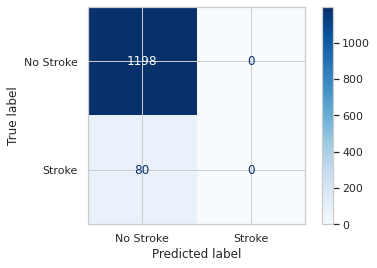

In [75]:
#creating confusion matrix for to supplement my justification for the best KNN model
labels=['No Stroke', 'Stroke']
knn_final_pipe_2 = make_pipeline(column_transformer, 
                               KNeighborsClassifier(n_neighbors = bestk))
knn_final_pipe_2.fit(X_train, y_train)

# Display confusion matrix for KNN with best k
plot_confusion_matrix(knn_final_pipe_2, X_test, y_test, cmap = 'Blues', display_labels=labels, values_format = 'd')

GridSearchCV

In [76]:
knn_pipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop':

In [77]:
pipe_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

##GridSearchCV on KNN 

In [78]:
# Note: takes 5-7 minutes to run
# using gridsearchcv to see if we knn will improve by finding best parameters
knn_pipe_gs = GridSearchCV(knn_pipe, pipe_param_grid)

knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.9366197183098591


>Out of all the models post tuned, Logistic Regression L1 performed best. When we balance the data set we capture more False Positives which is favorable for our goal, but it will also require more of our patients to visit the hospital for false check-ups.

#Principle Component Analysis for Dimensionality Reduction

In [79]:
# retaining 95% of variance
pca = PCA(n_components=.95)

In [80]:
# creating and fiting knn model with pca
knn_pca_pipe = make_pipeline(column_transformer, pca, KNeighborsClassifier())
knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f38a79ed250>)])),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [81]:
%%time
preds_pca = knn_pca_pipe.predict(X_test)

CPU times: user 114 ms, sys: 82.1 ms, total: 196 ms
Wall time: 104 ms


In [82]:
# evaluating the model using a classification_report
print(classification_report(y_test, preds_pca))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



>The run time for a model with PCA is faster than model with no PCA.

In [83]:
%%time
preds_no_pca = knn_pipe_2.predict(X_test)

CPU times: user 196 ms, sys: 116 ms, total: 312 ms
Wall time: 194 ms


In [84]:
# Evaluate the model using classification_report
print(classification_report(y_test, preds_no_pca))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Conclusion


##Logistic Regression used for production

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



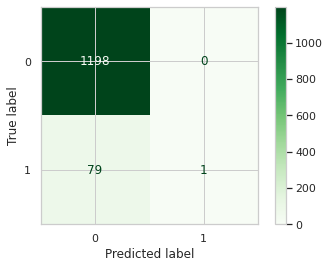

In [85]:
# classification report
evaluate_classification(log_reg_pipe, X_test, y_test)

In [103]:
#printing the accuracy of the training and test score
print('L1 Tuned Logistic Regression Training Accuracy')
print(log_reg_pipe.score(X_train, y_train))
print('\nL1 Tuned Logistic Test Accuracy')
print(log_reg_pipe.score(X_test, y_test))

L1 Tuned Logistic Regression Training Accuracy
0.9558977035490606

L1 Tuned Logistic Test Accuracy
0.9381846635367762


>Even after an L1 Tune our model didn't improve from the Baseline. Logistic Regression, however, performed the best. This is the model I would use for production and if I had more time I would try other hyperparameter tuning methods, such as L2 and GridSearchCV.

#Considerations
1. Balancing the data set or using SMOTE allowed more False Positive to be introduced during prediction, which may be more favorable for our client despite a decrease in accuracy.

2. Suggest our client focus on providing regular check-ups for patients over the age of 40 with frequent visits (every 6 months) to ensure early detection of stroke using our model. 

3. If I had more time, I would ask the client to provide other medical features that show better correlation (heatmap) to stroke in attempt to improve our model's performance.